## Read in JCMB weather station data

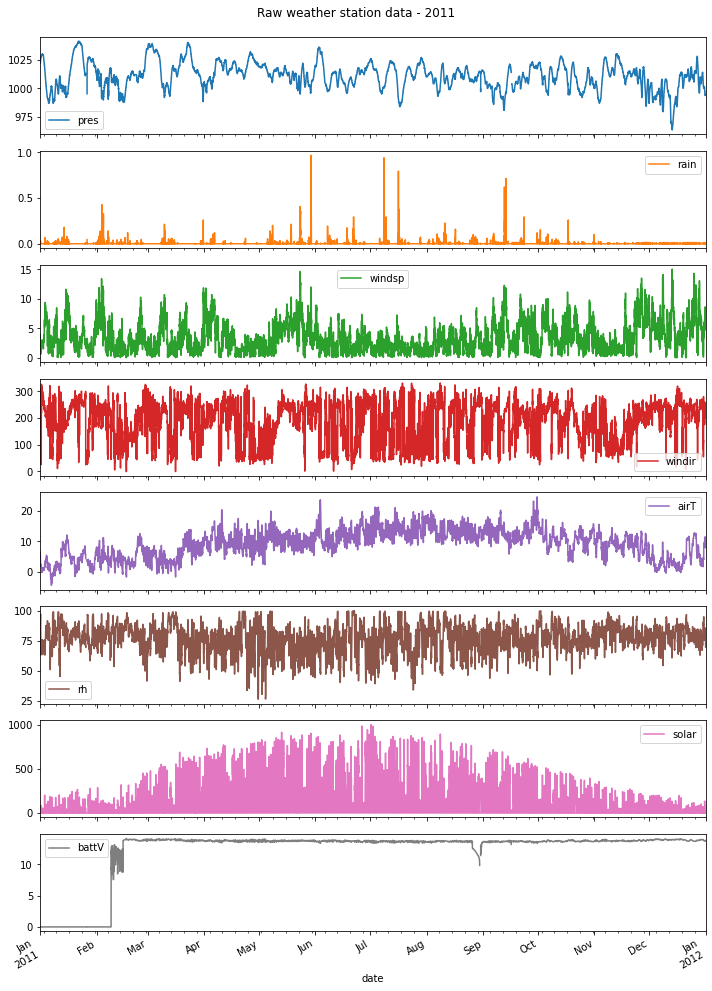

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import datetime as dt
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt
import pysolar
import pytz
inpath = ""

# About:
# script to read in a weather station file from JCMB
# and calculate the ratio of observed to modelled solar radiation
# so that relative cloudiness can be estimated

# Version 0.1   JBM  22 Feb 2020
# Latest: 20:00  28 March 2020

# Enter the year you want to work on below
year = 2011

infilename = inpath+"JCMB_"+str(year)+".csv"

df = pd.read_csv(infilename, sep=",", skiprows=2, header=None,
                     names=['date-time', 'pres', 'rain', 'windsp', 'windir',
                            'airT', 'rh', 'solar', 'battV'])

#################################################
# A peculiarity of the JCMB weather station data is that
# midnight is recorded as 24:00 on the preceding day
# eg 2006/05/01 24:00  should be 2006/05/02 00:00
# This is not compatible with the python %H parameter (which only goes from 0 to 23)
# so we need to edit the raw data file first
# Solution proposed here: https://stackoverflow.com/questions/52688645/

# find datetimes which have '24:00' and rewrite
df['datetime_zero'] = df['date-time'].str.replace('24:00','0:00')

df['datetime_er'] = pd.to_datetime(df['datetime_zero'], format='%Y/%m/%d %H:%M')
selrow = df['date-time'].str.contains('24:00')
df['date-time1'] = df['datetime_er'] + selrow * timedelta(days=1)
df['date'] = pd.to_datetime(df['date-time1'], format='%Y/%m/%d %H:%M')
df.set_index('date', inplace=True)
df['solar'] *= 1000  # convert to W m-2

startTime = pd.to_datetime(df.index[0])
timezone = pytz.timezone('Europe/London')
endTime = pd.to_datetime(df.index[-1])

df = df.resample('30T').mean()
#print(df.head())
# Just have a look at all the raw data first
df.plot(subplots=True, figsize=(10, 14), title='Raw weather station data'+' - '+str(year))
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Now calculate max potential hourly solar radiation at JCMB

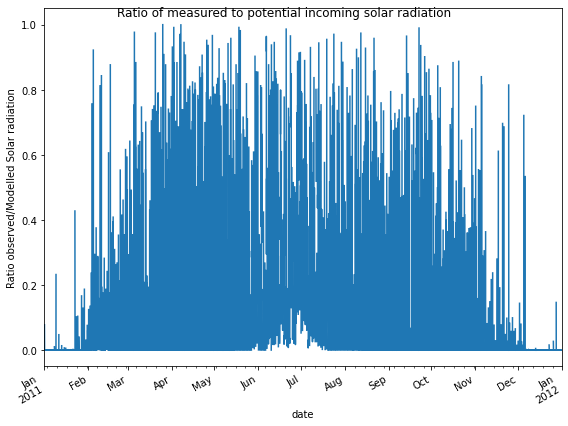

In [2]:
# https://earthscience.stackexchange.com/questions/14491/how-to-calculate-the-solar-radiation-at-any-place-any-time
lat, lon = 55.913168, -3.159998  # JCMB, KB, Edinburgh  (Liberton at the mo)
# Calculate radiation every hour in the year currently selected
maxrad = list()
r, c = df.shape    # how many rows and columns are in the original dataframe?

for ihr in range(0, r):
    date = startTime + dt.timedelta(hours=ihr)
    date = timezone.localize(date)
    altitude_deg = pysolar.solar.get_altitude(lat, lon, date)
    if altitude_deg <= 0:
        smax = 0.
    else:
        smax = pysolar.radiation.get_radiation_direct(date, altitude_deg)
    maxrad.append(smax)

# add the new list to the existing dataframe
df['maxs'] = maxrad
df['sratio'] = df['solar']/df['maxs']
# some sratios > 1 exist so get rid of them
df.loc[df['sratio'] > 1, 'sratio'] = np.NAN

df['sratio'].plot(subplots=True, figsize=(8,6), title='Ratio of measured to potential incoming solar radiation')
plt.ylabel('Ratio observed/Modelled Solar radiation')
plt.tight_layout()

## Repeat for a specific time interval

NameError: name 'ax' is not defined

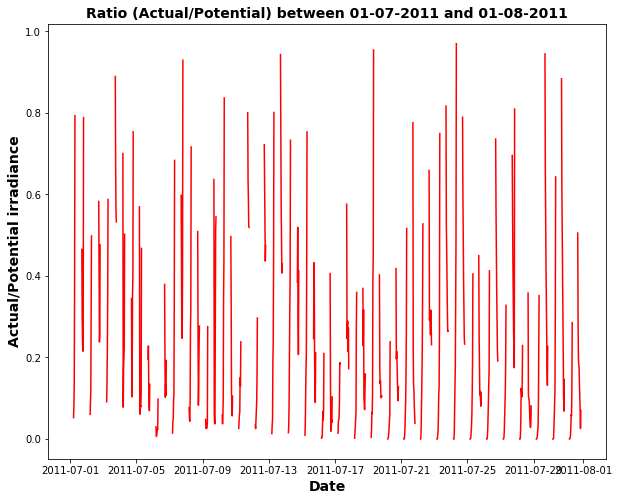

In [3]:
starttime = dt.datetime.strptime('2011-07-01', '%Y-%m-%d')
endtime = dt.datetime.strptime('2011-08-01', '%Y-%m-%d')
mask = (df.index > starttime) & (df.index <= endtime)
#print(df.loc[mask])
df1 = df.loc[mask]
plt.figure(figsize=(10,8))
plt.plot(df1.index, df1.sratio, color='red')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Actual/Potential irradiance', fontsize=14, fontweight='bold')
plt.title('Ratio (Actual/Potential) between '
       + dt.datetime.strftime(starttime, '%d-%m-%Y') +' and '
       + dt.datetime.strftime(endtime, '%d-%m-%Y'), fontsize=14, fontweight='bold')
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show

## Now read in METAR data from Edinburgh Airport (code EGPH)

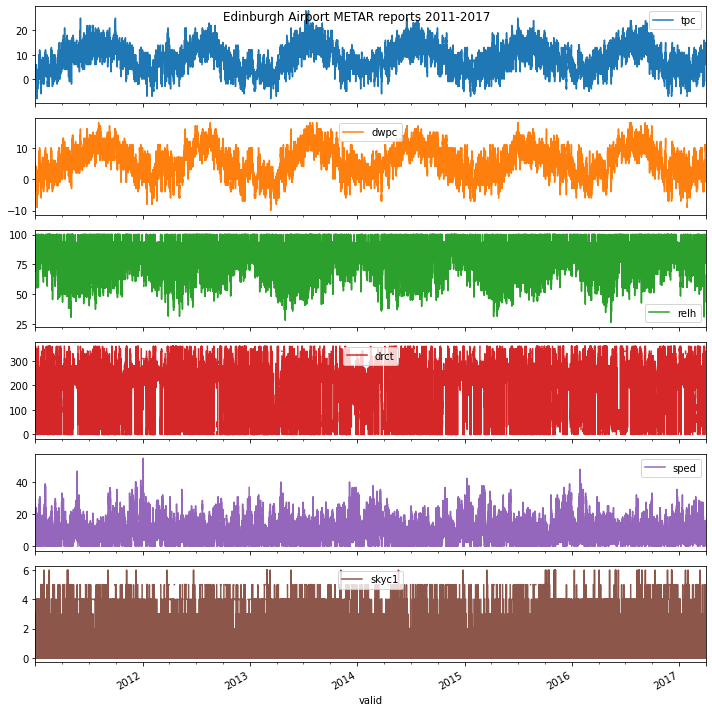

In [4]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta

from numpy import float32
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
inpath = ''

# Get the name of the input file with raw weather data from JCMB
infilename = inpath+'EGPH_2011_2017.csv'
headers = ['station', 'valid', 'tpc', 'dwpc', 'relh', 'drct', 'sped', 'skyc1']
# types = {'station': 'str', 'valid': 'str', 'tmpc': 'float', 'dwpc': 'float', 'relh' : 'float', 'drct' : 'float',
#          'sped': 'float', 'skyc1': 'str'}

### Had to clean up the original data file since there's a mixture of numbers and strings (in skyc1 column)
###  and Pandas only takes one type of object at a time ie all numbers OR all strings etc but not both.
### So - replaced the skycn code with an integer number as follows:
### few = 0, skt = 1, bkn = 2, ovc = 3, ncd = 4, nsc = 5, VV = 6
### where the following Table converts to oktas of cloud cover:
###   Abbreviation   Oktas          Code used in skyc1 column
###      few         1-2                0
###      skt         3-4                1
###      bkn         5-7                2
###      ovc         8                  3
###      ncd         no cloud detcd     4
###      nsc         nil cloud          5
###      VV          cannot see cloud   6
###                    ie fog
### see: https://en.wikipedia.org/wiki/METAR#International_METAR_codes

df3 = pd.read_csv(infilename, sep=',', skiprows=6, header=None, names=headers)  # dtype=types)
#print(df3.head())
# Make the timestamp the index for the file
df3['valid'] = pd.to_datetime(df3['valid'], format='%d/%m/%Y %H:%M')
df3.set_index('valid', inplace=True)
# Take the mean over 30 minutes ie 30T 
# but note that observations are at 20 minutes past the hour and 10 minutes to - so need to fix this.
df3=df3.resample('30T').mean()
#print(df3.head())
# Put all the data into ONE big plot
df3.plot(subplots=True, figsize=(10, 10), title = 'Edinburgh Airport METAR reports 2011-2017')
plt.tight_layout()
plt.show()

## Just plot sky conditions - (plotting as codes 0 = few, 1 = skt etc)

Text(0, 0.5, 'Cloudiness code')

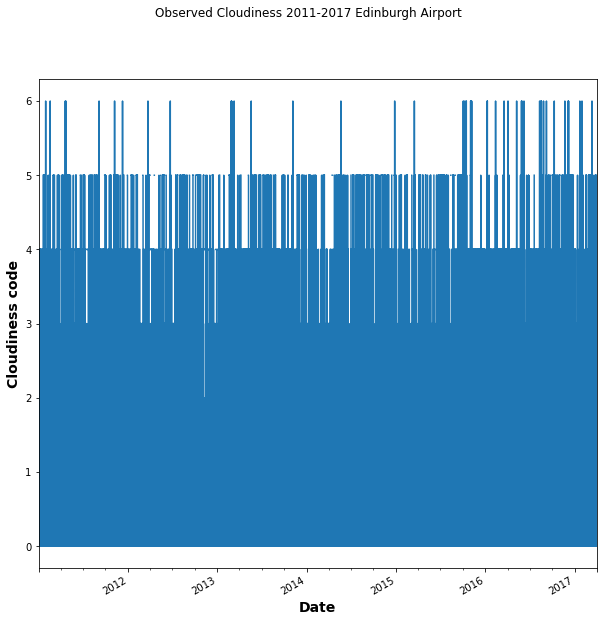

In [5]:
df3['skyc1'].plot(subplots=True, figsize=(10, 10), title='Observed Cloudiness 2011-2017 Edinburgh Airport')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Cloudiness code', fontsize=14, fontweight='bold')

<function matplotlib.pyplot.show(*args, **kw)>

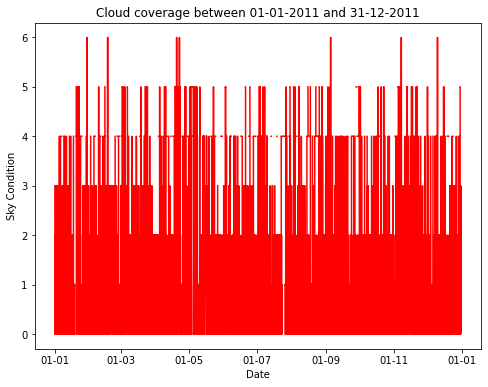

In [7]:
# Now just plot a year's worth of data so we can compare with JCMB data above
starttime = dt.datetime.strptime('2011-01-01', '%Y-%m-%d')
endtime = dt.datetime.strptime('2011-12-31', '%Y-%m-%d')
mask = (df3.index > starttime) & (df3.index <= endtime)
df4 = df3.loc[mask]
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(df4.index, df4['skyc1'], color='red')
ax.set(xlabel='Date',ylabel='Sky Condition',
       title='Cloud coverage between '
       + dt.datetime.strftime(starttime, '%d-%m-%Y') +' and '
       + dt.datetime.strftime(endtime, '%d-%m-%Y'))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show


## Plot the ratio of observed/modelled vs the sky condition - what do we see?
## Hypothesis is that high ratios should correspond with skyc1 around 0 or 1
## and low ratio should be in overcast conditions ie skyc1 around 2 or 3

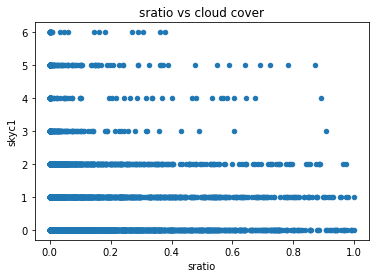

In [7]:
# Need to merge the ratio and skyc1 dataframes first based on time index
# merge across columns
df5 = pd.concat([df['sratio'], df4['skyc1']], axis=1)

df5.plot.scatter(x='sratio', y='skyc1', title='sratio vs cloud cover')
# remember these are the codes
###   Abbreviation   Oktas          Code used in skyc1 column
###      few         1-2                0
###      skt         3-4                1
###      bkn         5-7                2
###      ovc         8                  3
###      ncd         no cloud detcd     4
###      nsc         nil cloud          5
###      VV          cannot see cloud   6
###                    ie fog

## Now need to convert the codes into stability index per half hour

## Base it on the Pasquill dispersion classes

<img src="img/Pasquill_classes.png" width="560" height="460">

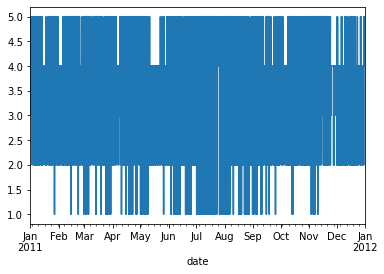

In [8]:
#  Merge the skyc1 code data df4['skyc1'] into the JCMB dataframe
# df4 has time and skyc1 for the chosen year
# df is main dataframe with one year's data
df['skyc1']=df4['skyc1']
# print(df.head(5))

# Now we have all we need in one dataframe - wind speed, irradiance and cloudiness
# NB - this is done a year-by-year basis at the moment

# Set up conditions so we can work out the stability on a per half-hour basis
# A = 1, B = 2, C = 3, D = 4, E = 5, F = 6
# Add in a stability column and make them all neutral to start ie code 4 (= Pasquill D)
df['stability'] = 4
#print(df['stability'].head(5))
#print(df.head())

# Must be a more pythonic way of doing this using list comprehension for example?
# The order of operation here is important

# Daytime, strong sunshine, windy = Pasquill 'C'
df['stability'] = np.where((df['windsp'] > 5)
                           & (df['solar'] > 500)
                           & (df['skyc1'] >2), #Identifies the case to apply to
                           3,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, strong sunshine, light-strong winds = Pasquill 'B'
df['stability'] = np.where((df['windsp'] < 5)
                           & (df['solar'] > 500)
                           & (df['skyc1'] <2), #Identifies the case to apply to
                           2,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, strong sunshine, light winds = Pasquill 'A'
df['stability'] = np.where((df['windsp'] < 2)
                           & (df['solar'] > 500)
                           & (df['skyc1'] ==0), #Identifies the case to apply to
                           1,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, moderate sunshine, windy = Pasquill 'C'
df['stability'] = np.where((df['windsp'] > 5)
                           & (df['solar'] < 500)
                           & (df['skyc1'] >2), #Identifies the case to apply to
                           3,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, moderate sunshine, light-strong winds = Pasquill 'B'
df['stability'] = np.where((df['windsp'] < 5)
                           & (df['solar'] < 500)
                           & (df['skyc1'] <2), #Identifies the case to apply to
                           2,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, moderate sunshine, light winds = Pasquill 'A'
df['stability'] = np.where((df['windsp'] < 2)
                           & (df['solar'] < 500)
                           & (df['skyc1'] <=1), #Identifies the case to apply to
                           1,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, slight sunshine, light-strong winds = Pasquill 'C'
df['stability'] = np.where((df['windsp'] < 5)
                           & (df['solar'] < 200)
                           & (df['skyc1'] ==1), #Identifies the case to apply to
                           3,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Daytime, slight sunshine, light-strong winds = Pasquill 'B'
df['stability'] = np.where((df['windsp'] < 2)
                           & (df['solar'] < 200)
                           & (df['skyc1'] ==0), #Identifies the case to apply to
                           2,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected

# Overcast day or night
df['stability'] = np.where((df['skyc1'] ==3), #Identifies the case to apply to
                           4,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Nightime >= 0.5 oktas = Pasquill 'E'
df['stability'] = np.where((df['windsp'] < 3)
                           & (df['solar'] < 5)
                           & (df['skyc1'] > 2), #Identifies the case to apply to
                           5,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected
# Nightime <= 0.4 oktas = Pasquill 'F'
df['stability'] = np.where((df['windsp'] < 2)
                           & (df['solar'] < 5)
                           & (df['skyc1'] ==0), #Identifies the case to apply to
                           6,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected

# Nightime <= 0.4 oktas light-strong winds  = Pasquill 'E'
df['stability'] = np.where((df['windsp'] < 3)
                           & (df['solar'] < 5)
                           & (df['skyc1'] <=1), #Identifies the case to apply to
                           5,                     #This is the value that is inserted
                           df['stability'])       #This is the column that is affected

#print(df.head(5))
df['stability'].plot()

#  NOW WE HAVE ALL THE DATA WE NEED! 
#  Start to analyse in terms of frequency distribution, windrose analysis and 
#  % time in each stability category by wind direction
#  So far - this is all done for only one year at a time
#  so either join all the data together OR do the analysis for each
#  year for which there is data and compare one year with another.


Text(0, 0.5, 'Frequency')

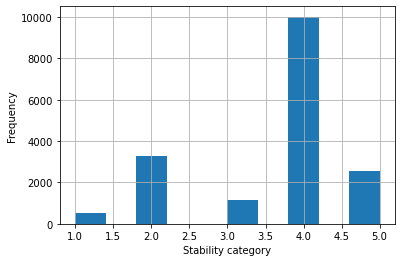

In [9]:
df['stability'].hist()
plt.xlabel('Stability category')
plt.ylabel('Frequency')

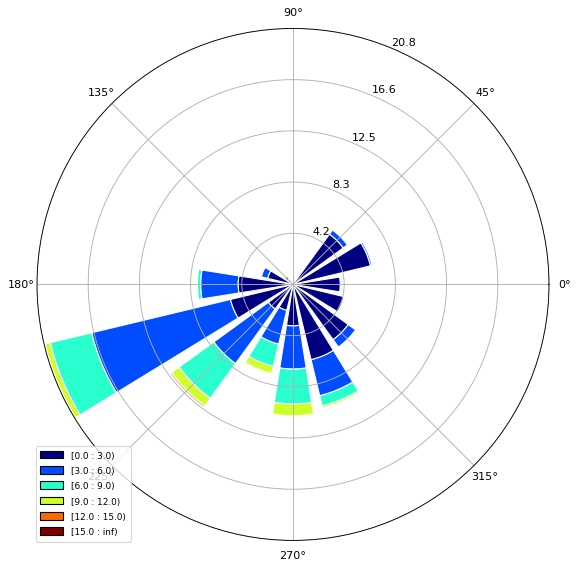

In [10]:
# https://github.com/python-windrose/windrose/
# You'll need to install this package eg 'conda install -c conda-forge windrose'
import windrose
from windrose import WindroseAxes
ws = df['windsp']
wd = df['windir']
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()